In this notebook,
we try to get two cliffs in a single data scaling plot
with classical sampling theory.

### Load libraries

In [1]:
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

### Ground truth functions

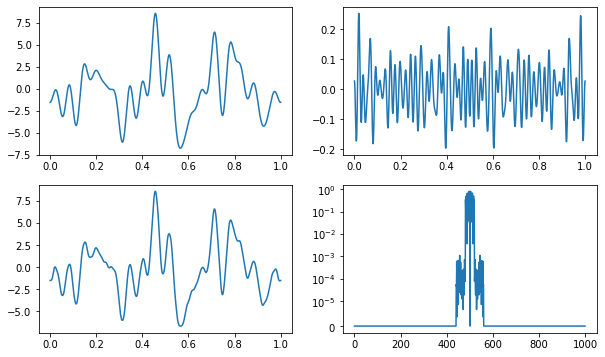

In [2]:
def f_base(xs: np.ndarray, amps: np.ndarray, lags: np.ndarray) -> np.ndarray:
    assert len(xs.shape) == 1
    assert amps.shape == lags.shape
    assert len(amps.shape) == 1

    x_times_arange = np.einsum("i,j->ij", xs, np.arange(len(amps)))
    ys = np.cos(2 * np.pi * x_times_arange + lags.reshape(1, -1)) @ amps
    return ys


np.random.seed(0)
AMPS_LO = np.random.normal(size=20)
LAGS_LO = 1 * np.pi * np.random.normal(size=len(AMPS_LO))
F_LO = lambda xs: f_base(xs, amps=AMPS_LO, lags=LAGS_LO)

AMPS_HI = 0.02 * np.random.normal(size=60)
AMPS_HI[:len(AMPS_LO)] = 0
LAGS_HI = 1e-2 * np.pi * np.random.normal(size=len(AMPS_HI))
F_HI = lambda xs: f_base(xs, amps=AMPS_HI, lags=LAGS_HI)

F_TRUE = lambda xs: F_LO(xs) + F_HI(xs)

plt.figure(figsize=(10, 6))
xs = np.linspace(0, 1, 1000)

plt.subplot(2, 2, 1)
plt.plot(xs, F_LO(xs))

plt.subplot(2, 2, 2)
plt.plot(xs, F_HI(xs))

plt.subplot(2, 2, 3)
plt.plot(xs, F_TRUE(xs))

plt.subplot(2, 2, 4)
xs = np.linspace(0, 1, 1000, endpoint=False)
dft = np.fft.fft(F_TRUE(xs), norm="forward")
plt.plot(np.fft.fftshift(np.abs(dft.imag)))
plt.yscale("symlog", linthresh=1e-5)


### Interpolation method
See https://numpy.org/doc/stable/reference/routines.fft.html
for helpful documentation on FFT math.

6.732048207102389e-29


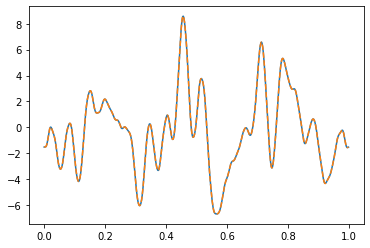

In [3]:
def interpolate(ys: np.ndarray) -> Callable[[np.ndarray], np.ndarray]:
    """
    1. Assumes ys[i] = f(i / len(ys))
    2. Assumes f(x) = f(x + 1).
    """
    (n,) = ys.shape

    # Perform a DFT
    coefs: np.ndarray = np.fft.rfft(ys, norm="forward")
    freqs: np.ndarray = np.fft.rfftfreq(n) * n

    def f_hat(xs: np.ndarray):
        xs_times_freqs = np.einsum("i, j -> ij", xs, freqs)
        cos_part = 2 * np.cos(2 * np.pi * xs_times_freqs) @ coefs.real
        sin_part = -2 * np.sin(2 * np.pi * xs_times_freqs) @ coefs.imag

        preds = cos_part + sin_part - coefs.real[0]
        return preds

    return f_hat

xs = np.linspace(0, 1, 1001, endpoint=False)
ys = F_TRUE(xs)
preds = interpolate(ys)(xs)
plt.plot(xs, ys)
plt.plot(xs, preds, linestyle="--")
print(np.square(preds - ys).mean())

### Scaling laws

In [4]:
np.random.seed(42)
xs_test = np.random.uniform(size=10000)
ys_test = F_TRUE(xs_test)

ns = np.arange(10, 200)
mses = []
for n in tqdm(ns):
    xs_train = np.linspace(0, 1, n, endpoint=False)
    ys_train = F_TRUE(xs_train)

    f_hat = interpolate(ys_train)
    preds = f_hat(xs_test)

    mse = np.square(ys_test - preds).mean()
    mses.append(mse)

mses = np.array(mses)

  0%|          | 0/190 [00:00<?, ?it/s]

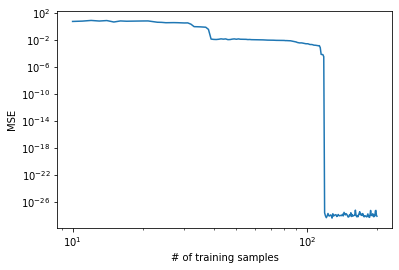

In [5]:
plt.plot(ns, mses)

plt.yscale("log")
plt.xscale("log")
plt.xlabel("# of training samples")
plt.ylabel("MSE");

### A nicer broken plot
Following guide from https://matplotlib.org/3.5.0/gallery/subplots_axes_and_figures/broken_axis.html

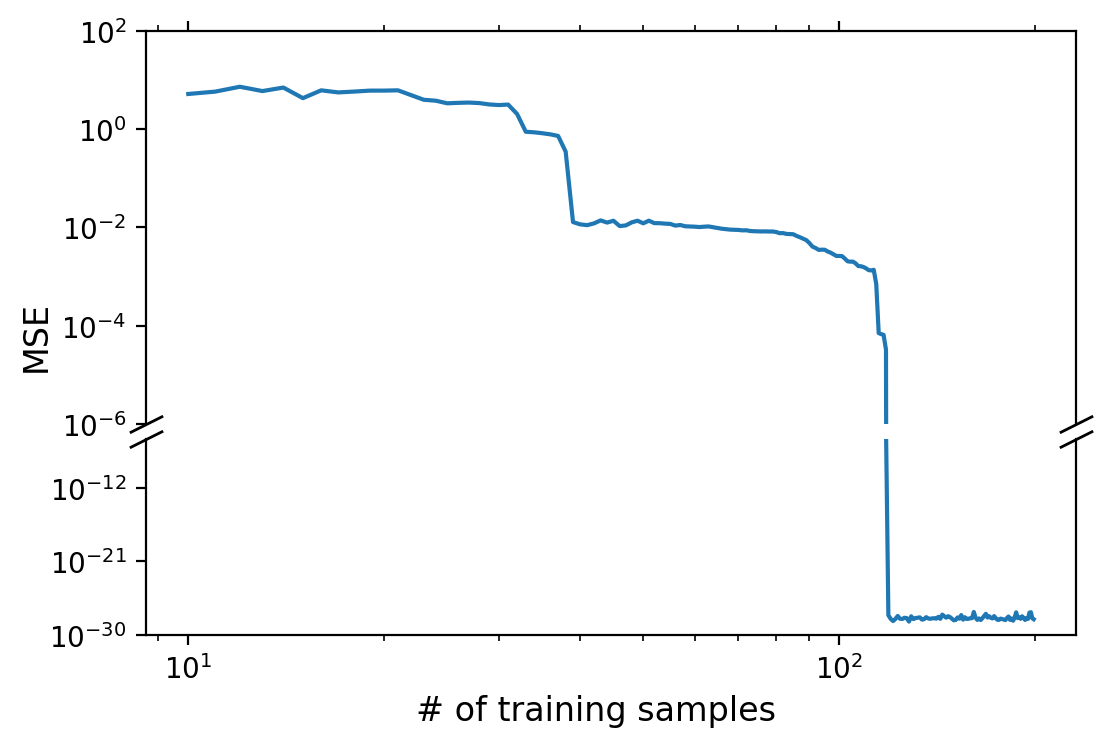

In [6]:
fig, (ax1, ax2) = plt.subplots(
    2,
    1,
    sharex=True,
    gridspec_kw={"height_ratios": [2, 1]},
    dpi=200
)
fig.subplots_adjust(hspace=0.05)  # adjust space between axes

ax1.plot(ns, mses)
ax2.plot(ns, mses)

ax1.set_yscale("log")
ax1.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xscale("log")

ax1.set_ylim(1e-6, 100)  # upper
ax2.set_ylim(1e-30, 1e-6)  # lower

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Now, let's turn towards the cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the axes size or scale
# Finally, we need to disable clipping.

d = 0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(
    marker=[(-1, -d), (1, d)],
    markersize=12,
    linestyle="none",
    color="k",
    mec="k",
    mew=1,
    clip_on=False,
)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

fig.supylabel("MSE")
fig.supxlabel("# of training samples")

plt.show()
